### Libraries

In [1]:
import numpy as np
import gym
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers

#### Initialize enviroment

In [2]:
env_name = "CartPole-v1"
env = gym.make(env_name)

### Neural Network

In [3]:
inputs = env.observation_space.shape # shape is (4,) in this case
actions_num = env.action_space.n
hidden_neurons = 256 # Arbitary choice

in_layer = layers.Input(shape=inputs)
hidden_layer = layers.Dense(hidden_neurons, activation="relu")(in_layer)
act_layer = layers.Dense(actions_num, activation="softmax")(hidden_layer)
val_layer = layers.Dense(1)(hidden_layer)

model = keras.Model(inputs=in_layer, outputs=[act_layer, val_layer])

### Parameter Initialization

In [4]:
gamma = 0.99 # Discount for future rewards
max_eps = 10**4
optimizer = keras.optimizers.Adam(learning_rate=0.01)
huber_loss = keras.losses.Huber()
ep_rewards = []


# Experience
reward_history = []
value_history = []
action_probs_history = []

# Arguments for display
count = 0
render = False # True for rendering every step
progress_eps = 10 # Progress will be shown every 10 episodes
# alt_win takes around 10mins to finish
alt_win = True # True for alternative winning condition hitting 500 reward mutliple times
consecutive_max_r = 10 # Number of times the agent needs to hit the maximum reward to be considered fully trained 

### Train

In [5]:
for ep in range(max_eps+1):
    state = env.reset()
    ep_reward = 0
    
    with tf.GradientTape() as tape:
        while True:
            # Get the NN output of current state
            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state, 0)
            action_probs, value = model(state)
            
            # Squeez Tensor to 1-d array
            np_probs = np.squeeze(action_probs)
            # Get random action based on probability array
            action = np.random.choice(actions_num, p=np_probs)
            # Take step, get new state
            state, reward, done, info = env.step(action)
            
            # Render enviroment
            if render:
                env.render()

            # Record experience
            reward_history.append(reward)
            value_history.append(value[0,0])
            action_probs_history.append(tf.math.log(action_probs[0, action]))

            # Episode accumulative reward
            ep_reward += reward
            
            if done:
                break

        # Save each episode rewards to see progress
        ep_rewards.append(ep_reward)

        # For each reward r calculate corresponding expected value based on experience gathered
        returns = [] # Expected value matrix for each action
        expected_reward = 0
        for r in reward_history:
            expected_reward = r + gamma * expected_reward
            returns.insert(0, expected_reward)

        # Normalize
        returns = np.array(returns)
        returns = (returns - np.mean(returns)) / (np.std(returns))
        returns = returns.tolist()

        # Calculate the loss
        history = zip(action_probs_history, value_history, returns)
        action_losses = []
        value_losses = []
        for log_prob, value, E_value in history:
            Advantage = value - E_value # The return we got minus the return we expected
            action_losses.append(log_prob * Advantage)  # Policy gradient loss

            value_losses.append( # Huber loss
                huber_loss(tf.expand_dims(value, 0), tf.expand_dims(E_value, 0))
            )
        total_loss = sum(value_losses) + sum(action_losses)

        # Backpropagation
        grads = tape.gradient(total_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        # Reset histories
        reward_history.clear()
        value_history.clear()
        action_probs_history.clear()

    # Show progress every 10 episodes
    if ep % 10 == 0:
        print(f"Episode: {ep},   Episode_Reward: {ep_reward}")
        print(f"Average reward of last 10 episodes: {sum(ep_rewards[ep-10:ep])/10}\n")

    # Winning condition defined by gym
    if ep == 99:
        avg_r_100 = sum(ep_rewards[ep-99:ep+1])/100
    elif ep > 99:
        if avg_r_100 > 195 and not alt_win:
            print("WINNING CONDITIONS MET!")
            if render: env.close()
            break
        avg_r_100 -= ep_rewards[ep-100]/100
        avg_r_100 += ep_rewards[ep]/100

    
    # If we hit the maximum possible reward
    if ep_reward == 500:
      count += 1
      print(f"Reached Maximum reward for the {count}th consecutive time")

      # Alternate winning condition (more promising)
      # If we hit it 8 consecutive times consider agent fully trained
      if count == consecutive_max_r and alt_win:
        print("AGENT TRAINED!\nHIT 8 CONSECUTIVE MAXIMUM REWARDS")
        if render: env.close()
        break
    else:
      count = 0

Episode: 0,   Episode_Reward: 30.0
Average reward of last 10 episodes: 0.0

Episode: 10,   Episode_Reward: 24.0
Average reward of last 10 episodes: 22.5

Episode: 20,   Episode_Reward: 94.0
Average reward of last 10 episodes: 35.7

Episode: 30,   Episode_Reward: 20.0
Average reward of last 10 episodes: 58.8

Episode: 40,   Episode_Reward: 10.0
Average reward of last 10 episodes: 17.4

Episode: 50,   Episode_Reward: 12.0
Average reward of last 10 episodes: 13.0

Episode: 60,   Episode_Reward: 9.0
Average reward of last 10 episodes: 12.5

Episode: 70,   Episode_Reward: 8.0
Average reward of last 10 episodes: 10.9

Episode: 80,   Episode_Reward: 10.0
Average reward of last 10 episodes: 11.0

Episode: 90,   Episode_Reward: 12.0
Average reward of last 10 episodes: 12.7

Episode: 100,   Episode_Reward: 11.0
Average reward of last 10 episodes: 16.3

Episode: 110,   Episode_Reward: 29.0
Average reward of last 10 episodes: 26.7

Episode: 120,   Episode_Reward: 81.0
Average reward of last 10 epi

### Test agent

In [6]:
def AgentTest():
  state = env.reset()
  total_reward = 0

  while True:
    state = tf.expand_dims(state,0)
    action, value = model(state)
    np_probs = np.squeeze(action)
    action = np.random.choice(actions_num, p=np_probs)      
    state, reward, done, info = env.step(action)
    total_reward += reward
    env.render()
    if done:
      break
  print(f"Total reward achieved: {total_reward}")
  env.close()

AgentTest()

Total reward achieved: 500.0


### Plot Reward Progress

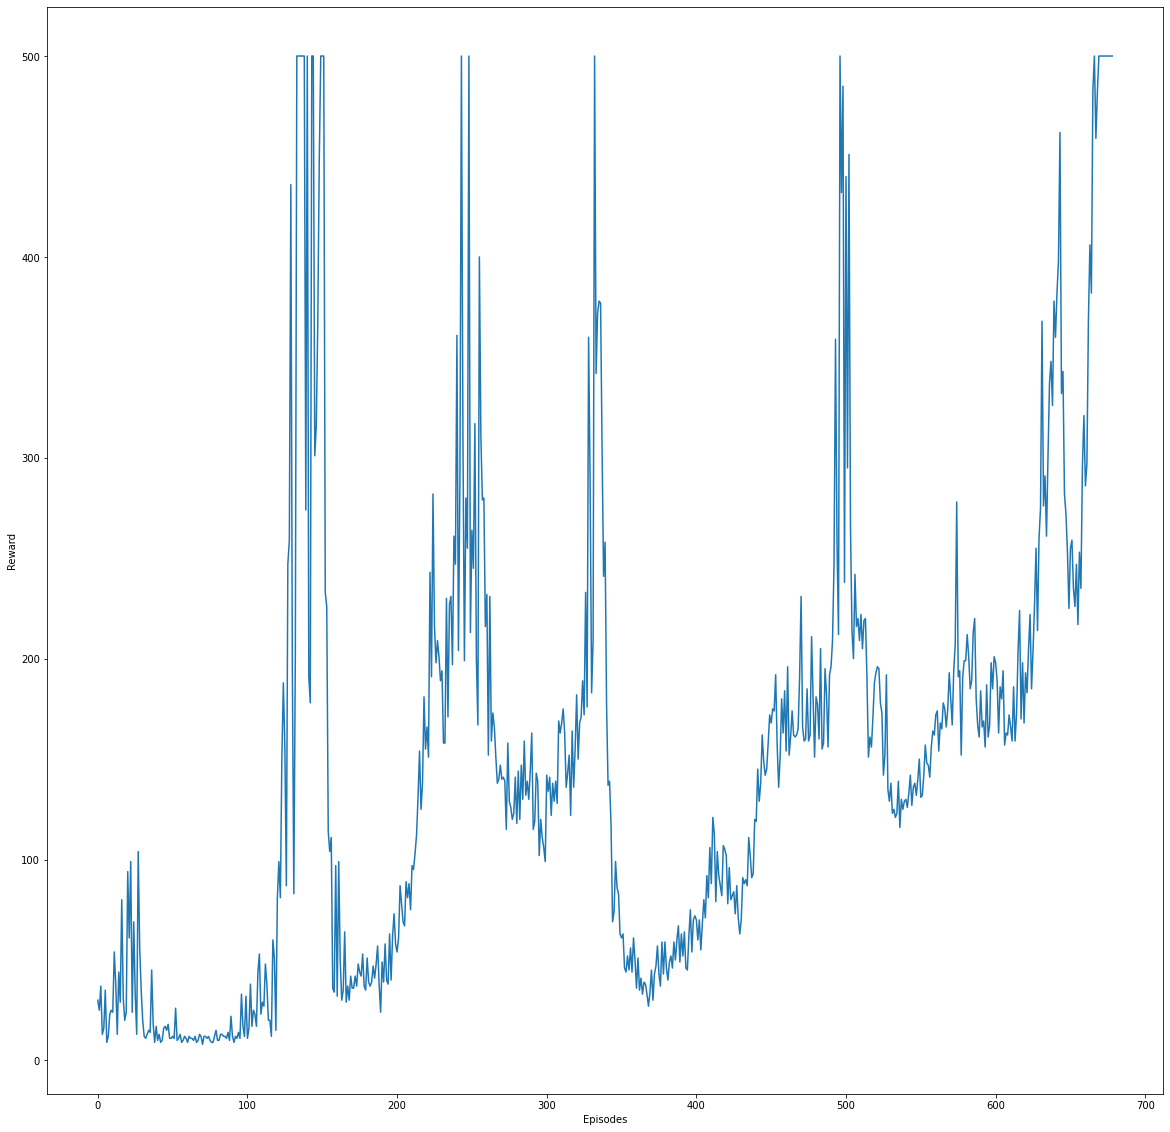

In [11]:
plt.figure(figsize=(20,20))
plt.plot(ep_rewards)
plt.ylabel("Reward"); plt.xlabel("Episodes")
plt.show()